In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency

In [26]:
file_path = r"C:\Users\komal\OneDrive\Desktop\Churn Analysis\Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)
print("Dataset Loaded Successfully!")
print(df.head())


Dataset Loaded Successfully!
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...         Yes   
4                No     Fiber optic             No  ...          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling 

In [27]:

# ============================================
# 2. CLEAN & TRANSFORM DATA (WARNING-FREE)
# ============================================

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill missing TotalCharges
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Convert SeniorCitizen to Yes/No
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1: "Yes", 0: "No"})

# Convert Churn to 1/0
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0}).astype(int)

print("Data Cleaning Completed Successfully (No Warnings)!")


Data Cleaning Completed Successfully (No Warnings)!


C:\Users\komal\AppData\Local\Temp\ipykernel_25096\2363326653.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0}).astype(int)



--- Usage Pattern Summary ---
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2281.916928
std      24.559481       30.090047   2265.270398
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


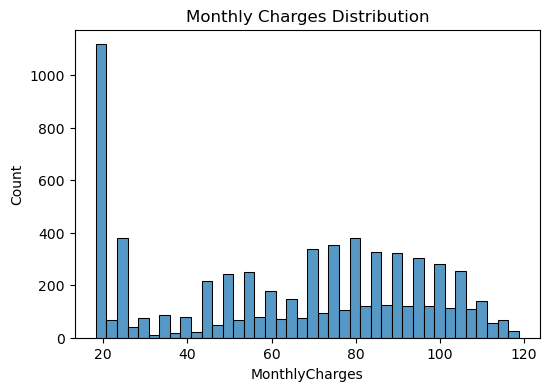

In [28]:

# ============================================
# 3. USAGE PATTERN ANALYSIS
# ============================================

print("\n--- Usage Pattern Summary ---")
print(df[["tenure", "MonthlyCharges", "TotalCharges"]].describe())

plt.figure(figsize=(6,4))
sns.histplot(df["MonthlyCharges"], bins=40)
plt.title("Monthly Charges Distribution")
plt.show()

In [29]:
# ============================================
# 4. GROUP BY DEMOGRAPHICS (Includes STATE)
# ============================================

churn_by_state = df.groupby("State")["Churn"].mean().sort_values(ascending=False)
print("\n--- Churn Rate by State ---")
print(churn_by_state)

churn_by_gender = df.groupby("gender")["Churn"].mean()
print("\n--- Churn Rate by Gender ---")
print(churn_by_gender)



--- Churn Rate by State ---
State
Himachal Pradesh    0.324713
Jharkhand           0.305263
Punjab              0.296791
Telangana           0.292350
West Bengal         0.281768
Kerala              0.277955
Uttar Pradesh       0.277473
Maharashtra         0.273556
Haryana             0.270557
Karnataka           0.269461
Madhya Pradesh      0.267380
Gujarat             0.266667
Uttarakhand         0.254743
Assam               0.250704
Tamil Nadu          0.248485
Odisha              0.245179
Bihar               0.237960
Goa                 0.230061
Rajasthan           0.220859
Chhattisgarh        0.200000
Name: Churn, dtype: float64

--- Churn Rate by Gender ---
gender
Female    0.269209
Male      0.261603
Name: Churn, dtype: float64


In [30]:
# ============================================
# 5. AVG REVENUE LOSS DUE TO CHURN
# ============================================

revenue_loss = df[df["Churn"] == 1]["MonthlyCharges"].sum()
avg_loss = df[df["Churn"] == 1]["MonthlyCharges"].mean()

print(f"\nTotal Revenue Lost due to Churn: ₹{revenue_loss:.2f}")
print(f"Average Revenue Lost per Churned Customer: ₹{avg_loss:.2f}")


Total Revenue Lost due to Churn: ₹139130.85
Average Revenue Lost per Churned Customer: ₹74.44



--- Correlation with Churn ---
Churn             1.000000
MonthlyCharges    0.193356
TotalCharges     -0.199037
tenure           -0.352229
Name: Churn, dtype: float64


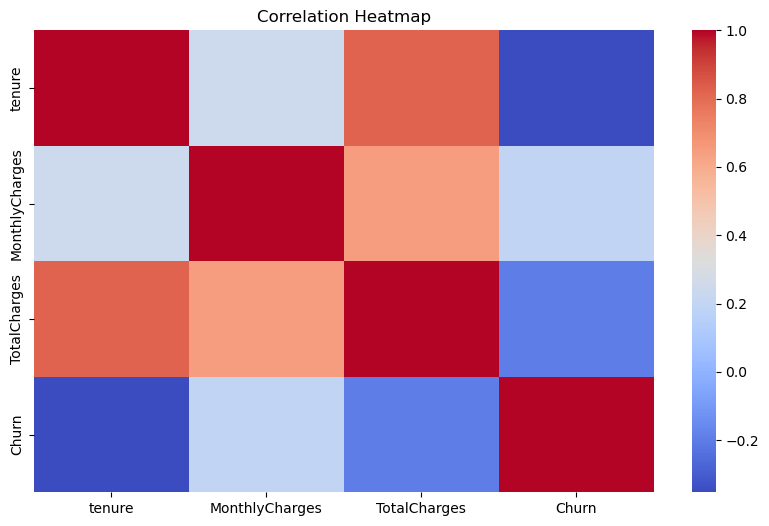

In [31]:
# ============================================
# 6. IDENTIFY KEY CHURN FACTORS
# ============================================

corr = df.corr(numeric_only=True)["Churn"].sort_values(ascending=False)
print("\n--- Correlation with Churn ---")
print(corr)

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



Cluster Counts:
Cluster
3    2276
1    1904
2    1704
0    1159
Name: count, dtype: int64


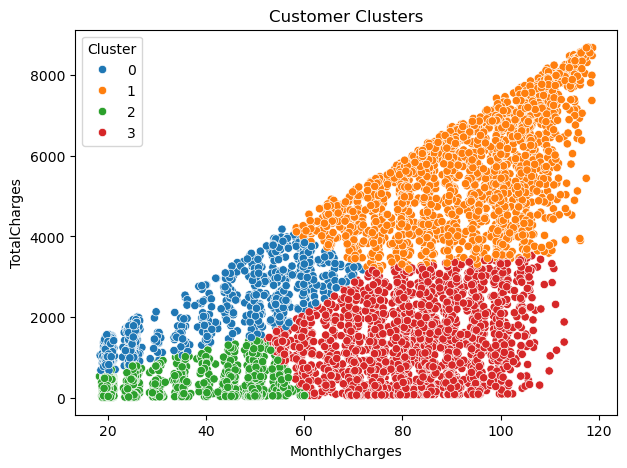

In [32]:
# ============================================
# 7. K-MEANS CLUSTERING
# ============================================

cluster_df = df[["tenure", "MonthlyCharges", "TotalCharges"]]

scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_df)

kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled)

print("\nCluster Counts:")
print(df["Cluster"].value_counts())

plt.figure(figsize=(7,5))
sns.scatterplot(x=df["MonthlyCharges"], y=df["TotalCharges"], hue=df["Cluster"], palette="tab10")
plt.title("Customer Clusters")
plt.show()


In [33]:
# ============================================
# 8. OPTIONAL - CHURN PREDICTION MODEL
# ============================================

from sklearn.preprocessing import LabelEncoder  # <-- REQUIRED IMPORT

le = LabelEncoder()
encoded_df = df.copy()

for col in encoded_df.select_dtypes(include="object").columns:
    encoded_df[col] = le.fit_transform(encoded_df[col])

print("Encoding completed successfully!")


Encoding completed successfully!
